### TRESC ZADANIA:
Plik "add_clicks.csv" zawiera dane o wyświetleniach reklam anonimowym użytkownikom odwiedzającym pewną stronę internetową.  

Zbiór obejmuje 100000 obserwacji i 7 kolumn:
ip: adres IP użytkownika 
variant: kod wariantu reklamy wyświetlanego użytkownikowi 
device: kod typu urządzenia (telefonu komórkowego) użytkownika 
os: kod wariantu system operacyjnego urządzenia użytkownika 
channel: kanał, w którym reklama została wyświetlona (np. Facebook, Google, itp.). 
click_time: znacznik czasu wyświetlenia reklamy (UTC) 
is_clicked: informacja czy reklama została kliknięta (0 = NIE, 1 = TAK) - zmienna celu do modeli 

In [22]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use("seaborn")
import scipy.stats as sp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import classification_report
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split

### Zadanie 0. Import data from "add_clicks.csv"

In [23]:
clicks = pd.read_csv('C:\\Users\\ANIA\\Desktop\\python\\PROJEKTY\\cube group\\wyslany plik\\add_clicks.csv')
# checking the data in case of missing values
print(clicks.isna().any())


ip            False
variant       False
device        False
os            False
channel       False
click_time    False
is_clicked    False
dtype: bool


### Zadanie 1. Proszę przeprowadzić analizę struktury danych z wykorzystaniem statystyk opisowych i wykresów.

In [24]:
# Initial analysis of variables indicates that all variables are categorical.
# printing out the dataset
print(clicks)
# Priting the frequency of categorical variables.
categ = list(clicks.columns)
counts = []
for i in categ:
    print(clicks.value_counts(i))  
    counts.append(clicks.value_counts(i))

           ip  variant  device  os  channel        click_time  is_clicked
0       87540       12       1  13      497  2017-11-07 09:30           0
1      105560       25       1  17      259  2017-11-07 13:40           0
2      101424       12       1  19      212  2017-11-07 18:05           0
3       94584       13       1  13      477  2017-11-07 04:58           0
4       68413       12       1   1      178  2017-11-09 09:00           0
...       ...      ...     ...  ..      ...               ...         ...
99995  124883       11       1  19      122  2017-11-09 13:25           0
99996   85150        9       1  13      244  2017-11-07 11:25           0
99997   18839        3       1  13       19  2017-11-08 11:38           0
99998  114276       15       1  12      245  2017-11-08 17:55           0
99999  119349       14       1  15      401  2017-11-07 14:32           0

[100000 rows x 7 columns]
ip
5348      669
5314      616
73487     439
73516     399
53454     280
         ...

In [25]:
# Plotting the categorical variables, showing only the most frequent instances.
def plot_category_count(variable, dataset,  title, no_cat = 19):
    # Plot 20 channels with the highest value
    # Sort the values in descending order
    clicks_value_count = dataset[variable].value_counts()
    # Select 20 highest values
    clicks_value_count = clicks_value_count[0:no_cat]
    # Convert to DataFrame
    clicks_value_count = pd.DataFrame(clicks_value_count)
    # Plot seaborn barplot
    plot = sns.barplot(x=clicks_value_count.index, y=variable, data=clicks_value_count, order=clicks_value_count.index).set_title(title) 

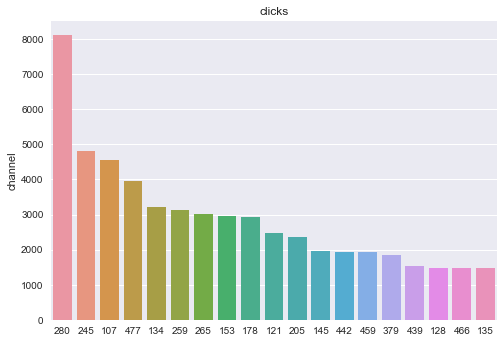

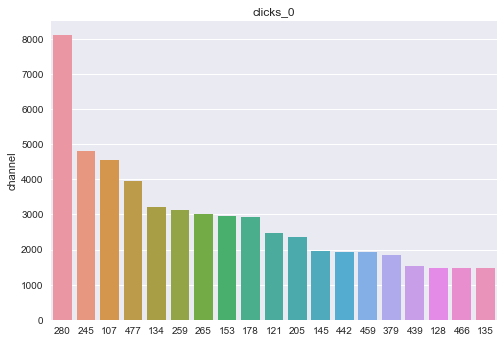

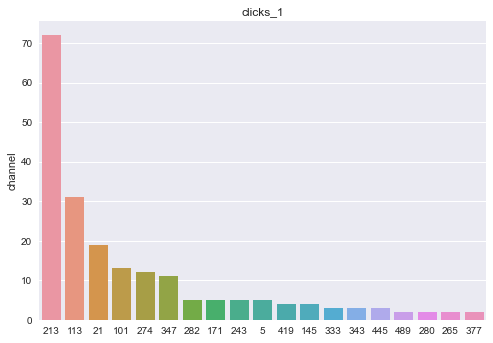

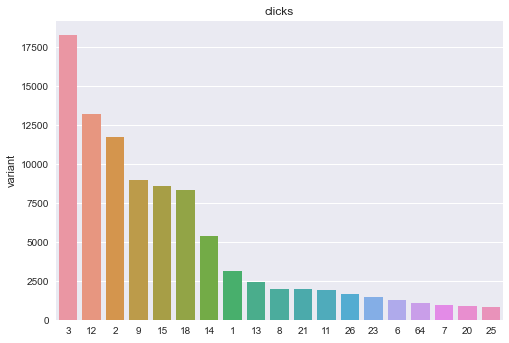

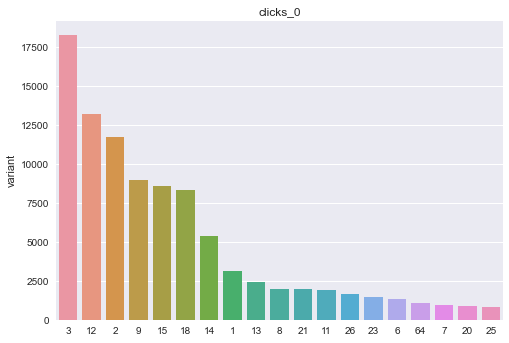

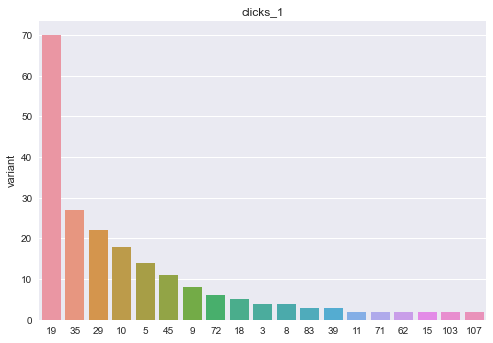

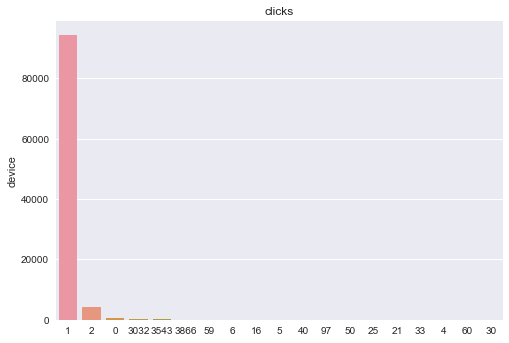

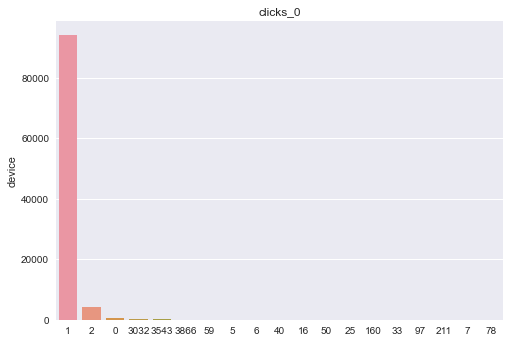

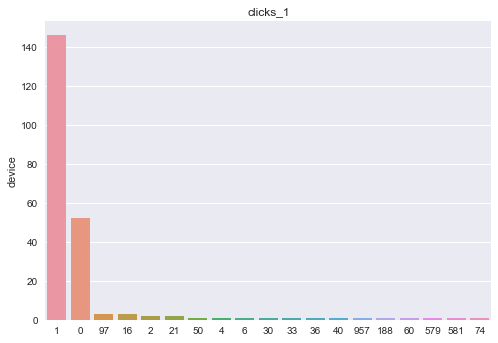

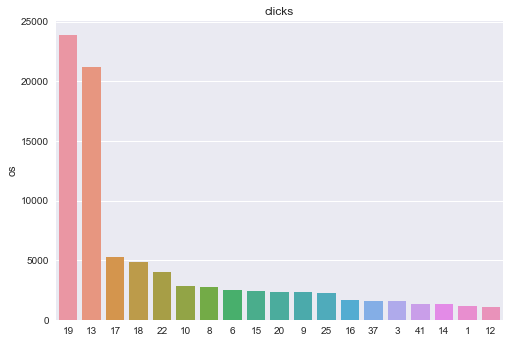

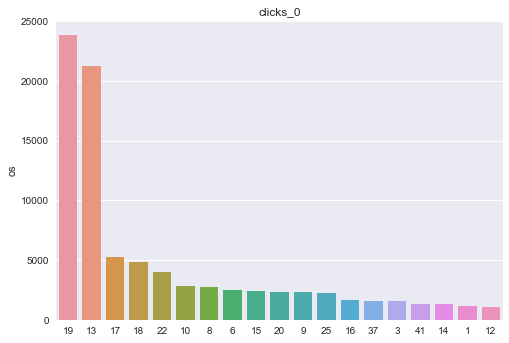

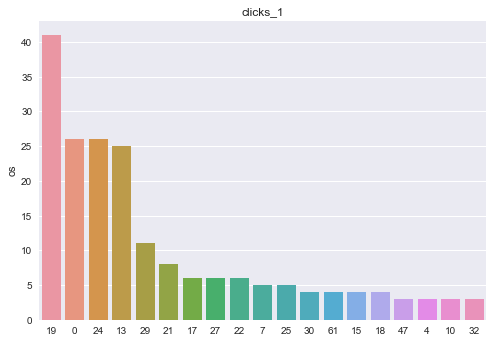

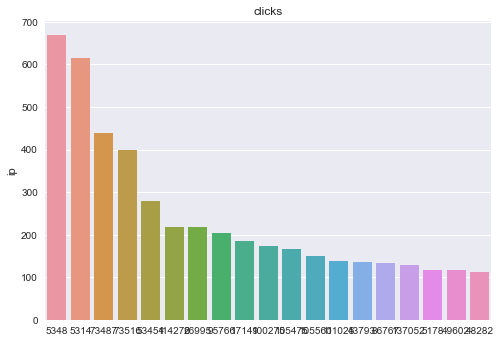

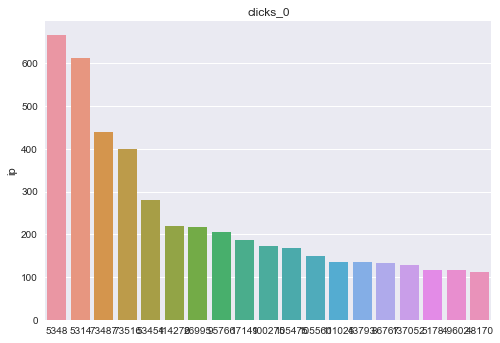

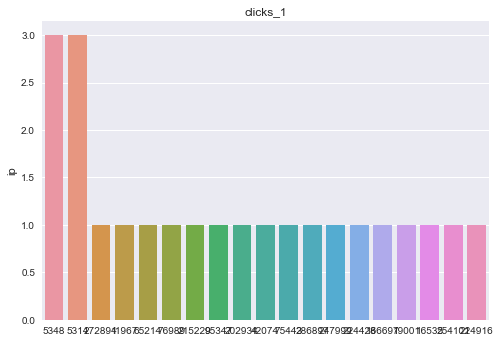

In [26]:
# Showing frequency for two datasets
clicks_0 = clicks[clicks["is_clicked"] == 0]
clicks_1 = clicks[clicks["is_clicked"] == 1]

plot_category_count("channel", clicks, "clicks")
plt.show()
plot_category_count("channel", clicks_0, "clicks_0" )
plt.show()
plot_category_count("channel", clicks_1, "clicks_1" )
plt.show()

plot_category_count("variant", clicks, "clicks")
plt.show()
plot_category_count("variant", clicks_0, "clicks_0")
plt.show()
plot_category_count("variant", clicks_1, "clicks_1")
plt.show()

plot_category_count("device", clicks, "clicks")
plt.show()
plot_category_count( "device", clicks_0, "clicks_0")
plt.show()
plot_category_count( "device", clicks_1, "clicks_1")
plt.show()

plot_category_count("os", clicks, "clicks")
plt.show()
plot_category_count("os", clicks_0, "clicks_0")
plt.show()
plot_category_count("os", clicks_1, "clicks_1")
plt.show()

plot_category_count("ip", clicks, "clicks")
plt.show()
plot_category_count( "ip", clicks_0, "clicks_0")
plt.show()
plot_category_count( "ip", clicks_1, "clicks_1" )
plt.show()

Powyzej przedstawione sa wykresy zmiennych objasniajacych przedstawiajacych najczesciej pojawiajace sie wartosci:
- Zmienna ip - adres IP użytkownika. Traktowana jako id i pominieta w analizie. 
- Zmienna variant opisuje kod reklamy. Najpopularniejsze wyswietlone reklamy to 19, 35 oraz 29.
- Zmienna device - kod urzadzenia telefonu. Pokazuje, ze urzadzenie 1 najczesciej wyswietla reklamy. W przypadku urzadzenia 0 jest stosunkowo duzo odnotowanych wyswietlen reklamy.
- Zmienna os - kod systemu operacyjnego. Systemy 0, 24, 13 mimo iz nie sa czesto targetowane, sa sklonne do czestego wyswietlania reklam. 
- Zmienna channel - kanał, w którym reklama została wyświetlona. Reklamy najczesciej zostaly wyswietlane dla kanałow 213, 113, 21.
- Zmienna click_time - czas wyświetlenia reklamy. W nastepnym paragrafie zmodyfikowałam ta zmienna. Czas zamieniłam na pore dnia. 

### Zadanie 2. Proszę zaproponować dodatkowe zmienne, które można utworzyć na podstawie dostępnych informacji i dodać je do zbioru danych.

Aby sprawdzic czy istnieje roznica miedzy wyswietlaniem reklam w roznych porach dnia, zmienna click_time została zamieniona na zmienna time_of_day o kategoriach morning, afternoon and night, bez uzwzglednienia dni. 

In [27]:
clicks.index = pd.to_datetime(clicks["click_time"], format='%Y-%m-%d %H:%M')
morning = clicks.between_time('6:00', '11:59', include_start=True, include_end=True) 
morning.insert(2, "time_of_day", ["morning"] * len(morning), True)

afternoon =  clicks.between_time('12:00', '17:59', include_start=True, include_end=True)
afternoon.insert(2, "time_of_day", ["afternoon"] * len(afternoon), True)

night = clicks.between_time('18:00', '05:59', include_start=True, include_end=True) 
night.insert(2, "time_of_day", ["night"] * len(night), True)

len(morning) + len(afternoon) + len(night)
final = pd.concat([morning, afternoon, night])
final = final.reset_index(drop=True)

# TO DO: opis nowych zmiennych

In [28]:
print(final)

           ip  variant time_of_day  device  os  channel        click_time  \
0       87540       12     morning       1  13      497  2017-11-07 09:30   
1       68413       12     morning       1   1      178  2017-11-09 09:00   
2      121505        9     morning       1  25      442  2017-11-07 10:01   
3      192967        2     morning       2  22      364  2017-11-08 09:35   
4       73839        3     morning       1  22      489  2017-11-08 08:14   
...       ...      ...         ...     ...  ..      ...               ...   
99995   51379        3       night       1  41      135  2017-11-07 01:48   
99996  185961       27       night       1  13      122  2017-11-07 05:02   
99997   61500        3       night       1  10      280  2017-11-09 01:50   
99998   84388        9       night       1  22      107  2017-11-09 04:21   
99999  146258        3       night       1  13      280  2017-11-09 03:03   

       is_clicked  
0               0  
1               0  
2              

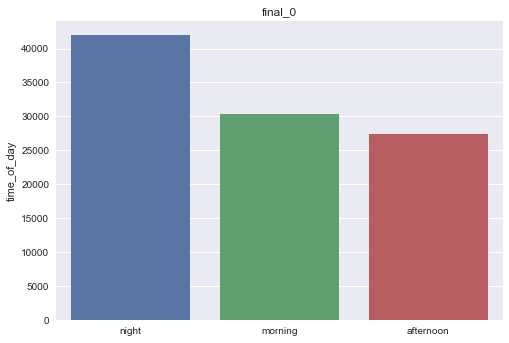

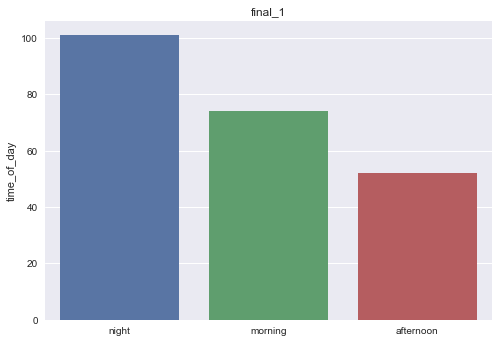

In [29]:
# Analysis of variable "time_of_day"
final_0 = final[final["is_clicked"] == 0]
final_1 = final[final["is_clicked"] == 1]
plot_category_count("time_of_day", final_0,  "final_0", no_cat = 3)
plt.show()
plot_category_count("time_of_day", final_1,  "final_1", no_cat = 3)
plt.show()

- Zmienna time_of_day wyglada podobnie dla wyswietlonych oraz nie wyswietlonych reklam. 

### Preparing data for analysis

In [30]:
# categorical data for models lightgmb and catboost 
clicks_Y_cat = final["is_clicked"]
clicks_X_cat = final.drop(["is_clicked", "ip", "click_time"], axis = 1) # deleting Y and ip 

In [31]:
### encoding categorical data for the rest of the models
clicks_Y = clicks_Y_cat
clicks_X = clicks_X_cat
categories = ["variant", "device", "os", "channel", "time_of_day"]
clicks_X = pd.get_dummies(clicks_X, columns = categories) # - to sa juz wszytkie dane tylko trzeba je przeskalowac
print(clicks_X)

       variant_1  variant_2  variant_3  variant_4  variant_5  variant_6  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
2              0          0          0          0          0          0   
3              0          1          0          0          0          0   
4              0          0          1          0          0          0   
...          ...        ...        ...        ...        ...        ...   
99995          0          0          1          0          0          0   
99996          0          0          0          0          0          0   
99997          0          0          1          0          0          0   
99998          0          0          0          0          0          0   
99999          0          0          1          0          0          0   

       variant_7  variant_8  variant_9  variant_10  ...  channel_487  \
0              0          0

### Zadanie 3. Proszę podzielić losowo zbiór danych na próbę uczącą i testową wg proporcji 70/30, tak aby proporcja kliknięć była zachowana w obu próbach (zachowując możliwość odtworzenia podziału -  ziarno losowania).

In [32]:
X_train, X_test, y_train, y_test = train_test_split(clicks_X, clicks_Y, test_size = 0.30, random_state = 1)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(clicks_X_cat, clicks_Y_cat, test_size = 0.30, random_state = 1)

### Zadanie 4. Proszę wstępnie zbadać zależności między zmienną celu a poszczególnymi predyktorami (również dodanymi przez siebie) w próbie uczącej i krótko skomentować wyniki.

In [33]:
# rejecting the variables by simple correlation
train_predictors = X_train.columns
# sp.pearsonr(X_train["time_of_day_night"], y_train)
table_cor = [sp.pearsonr(X_train[i], y_train) for i in train_predictors]
table_cor_full = pd.DataFrame(table_cor, index=train_predictors, columns=["cor_coef", "p-value"]).sort_values("cor_coef", ascending=False)
# decision making rule
choosen_variables = table_cor_full.query("cor_coef >= 0.05 or cor_coef <= -0.05").index
print(choosen_variables)
# X after choosing variables
X_train = X_train[choosen_variables]
X_test = X_test[choosen_variables]
print(X_train)

C:\Users\ANIA\anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Index(['variant_35', 'channel_213', 'channel_274', 'variant_19', 'device_0',
       'os_61', 'channel_5', 'variant_45', 'os_0', 'variant_72', 'channel_113',
       'os_24', 'channel_419', 'variant_71', 'channel_21', 'os_29',
       'variant_34', 'channel_282', 'variant_116', 'variant_96', 'device_116',
       'device_188', 'variant_261', 'device_36', 'device_56', 'device_102',
       'channel_465', 'variant_115', 'device_97', 'variant_29', 'variant_5',
       'variant_39', 'channel_171', 'variant_10', 'variant_108', 'device_33',
       'device_30', 'device_74', 'device_109', 'variant_48', 'device_21',
       'device_4', 'channel_333', 'device_1'],
      dtype='object')
       variant_35  channel_213  channel_274  variant_19  device_0  os_61  \
80630           0            0            0           0         0      0   
62017           0            0            0           0         0      0   
5005            0            0            0           0         0      0   
56849           0 

Zbadałam zależność między zmienną Y a każdą zmienną X. Obliczyłam współczynnik korelacji Pearsona dla każdej pary. Następnie wybrałam zmienne dla których korelacja jest większa od 0,05 oraz mniejsza od -0,05. Sposród 555 zmiennych wybrane zostały 44 zmienne.


### Zadanie 5. Na zbiorze uczącym proszę oszacować model regresji logistycznej, wyjaśniający prawdopodobieństwo kliknięcia w reklamę w zależności od innych sensownych zmiennych. 

In [34]:
#Logistic Regression
classifier_log = LogisticRegression(random_state = 0)
classifier_log.fit(X_train, y_train)
# Predicting the Test set results for TRAINING data!!!!
y_pred_log = classifier_log.predict(X_train)
# Predicting the Test set results for TRAINING data!!!!
y_pred_log_test = classifier_log.predict(X_test)

### Zadanie 6 Proszę ocenić jakość dopasowania modelu regresji logistycznej licząc dla próby uczącej: accuracy, sensitivity, specificity, AUCROC, F1 oraz rysując wykres krzywej ROC. Czy model jest dobrze dopasowany? Prośba o krótki komentarz i interpretację wyników. 


Wyniki dla modelu regresji logistycznej: (wyniki pochodza z tabeli z zadania 8 ) 
- accuracy = 0.997686 
- ROC score  = 0.534869 
- recall (sensitivity) = 0.069767 
- precision = 0.857143
- F1 score = 0.129032 
- support = 172.0 

Pierwsza miara, accuracy, jest wysoka co wskazywałoby na to, że model dobrze klasyfikuje obserwacje.
W zbiorze mamy dane z duża ilością 0 i z mała ilością 1. Jeśli model dobrze dopasowuje zera to osiągnie wysokie accuracy. 
ROC score wynosi około 0,5 co wskazuje na przeciętne dopasowanie modelu do danych.
Miara Recall jest niska, co wskazuje na niska umiejetnosc znajdowania pozytywnych predykcji. 
Miara Precision jest wysoka tzn. rzadko klasyfikuje jako 1 obserwacje, ktora w rzeczywistosci przyjmuje 0. 
Niski F1 score wynika z niskiej wartosci recall.
Support score jest bardzo mały względnem wielkości próby, przez co samo wysokie accuracy może być mylące. Model klasyfikujacy wszystkie obserwacje jako 0 miałby wysokie accuracy ze względu na wysoką ilość faktycznych 0 w zbiorze.

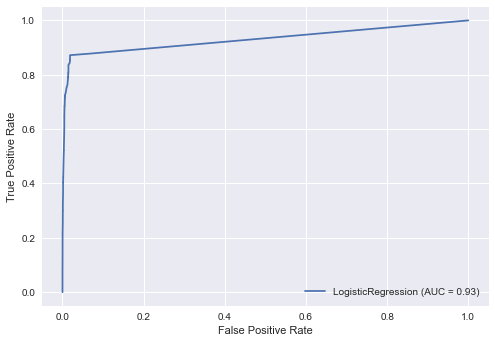

In [35]:
# ROC 
ax = plt.gca()
plot_roc_curve(classifier_log, X_train, y_train, ax=ax)

### Zadanie 7. Na zbiorze uczącym proszę oszacować inne modele, między innymi las losowy, xgboost, catboost, lightgbm oraz co najmniej DWA inne wybrane przez siebie modele (uzasadniając krótko ich wybór).

In [36]:
## Random Forest
classifier_forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest.fit(X_train, y_train)
y_pred_forest = classifier_forest.predict(X_train)
y_pred_forest_test = classifier_forest.predict(X_test)

In [37]:
## xgboost
classifier_xgb = XGBClassifier(random_state=42, n_estimators = 300, max_depth = 5, learning_rate = 0.1)
classifier_xgb.fit(X_train, y_train)
y_pred_xgb = classifier_xgb.predict(X_train)
y_pred_xgb_test = classifier_xgb.predict(X_test)

C:\Users\ANIA\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ANIA\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [38]:
## Kernel SVM
classifier_svm = SVC(kernel = 'rbf', random_state = 0)  # rbf radial basis function - most popular 
classifier_svm.fit(X_train, y_train)             
y_pred_kernel_svm = classifier_svm.predict(X_train)
y_pred_kernel_svm_test = classifier_svm.predict(X_test)

In [39]:
## Decision Tree
classifier_tree  = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_tree.fit(X_train, y_train)
y_pred_tree = classifier_tree.predict(X_train)
y_pred_tree_test = classifier_tree.predict(X_test)

In [40]:
## Catboost
# X_train_cat.columns, X_test_cat, y_train_cat, y_test_cat 
## CatBoost is a machine learning algorithm that uses gradient boosting on decision trees.
classifier_catb = CatBoostClassifier(iterations=20)
classifier_catb.fit(X = X_train_cat, y = y_train_cat, cat_features = list(X_train_cat.columns)) 
# Predicting the Test set results for TRAINING data!!!!
y_pred_catb = classifier_catb.predict(X_train_cat)
y_pred_catb_test = classifier_catb.predict(X_test_cat)

Learning rate set to 0.5
0:	learn: 0.3170886	total: 22ms	remaining: 418ms
1:	learn: 0.1760570	total: 34ms	remaining: 306ms
2:	learn: 0.1050171	total: 46.4ms	remaining: 263ms
3:	learn: 0.0661674	total: 60.8ms	remaining: 243ms
4:	learn: 0.0442357	total: 75ms	remaining: 225ms
5:	learn: 0.0317653	total: 98.5ms	remaining: 230ms
6:	learn: 0.0247447	total: 118ms	remaining: 218ms
7:	learn: 0.0178781	total: 154ms	remaining: 231ms
8:	learn: 0.0148423	total: 194ms	remaining: 237ms
9:	learn: 0.0132937	total: 236ms	remaining: 236ms
10:	learn: 0.0122659	total: 288ms	remaining: 236ms
11:	learn: 0.0112093	total: 328ms	remaining: 219ms
12:	learn: 0.0104577	total: 361ms	remaining: 195ms
13:	learn: 0.0100306	total: 429ms	remaining: 184ms
14:	learn: 0.0097525	total: 506ms	remaining: 169ms
15:	learn: 0.0095200	total: 544ms	remaining: 136ms
16:	learn: 0.0091652	total: 579ms	remaining: 102ms
17:	learn: 0.0091131	total: 624ms	remaining: 69.4ms
18:	learn: 0.0090510	total: 655ms	remaining: 34.5ms
19:	learn: 0.0

In [41]:
## lightgbm
classifier_lgbm = LGBMClassifier(objective= "binary", metric ='auc', boosting_type ='gbdt')

X_train_cat["time_of_day"].replace({'morning': 1, 'afternoon' : 2,'night': 3}, inplace=True)
X_test_cat["time_of_day"].replace({'morning': 1, 'afternoon' : 2,'night': 3}, inplace=True)


classifier_lgbm.fit(X = X_train_cat, y = y_train_cat, categorical_feature = list(X_train_cat.columns))
y_pred_light = classifier_lgbm.predict(X_train_cat)
y_pred_light_test = classifier_lgbm.predict(X_test_cat)

C:\Users\ANIA\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\ANIA\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


####  Dodatkowe modele:
- Wybrano Decision Tree, używany jako benchmark do porówania z modelami XG Boost oraz Random Forest.
- Kernel CVM wybrano na podstawie wczesniejszych analiz, z powodu dobrych mocy predykcyjnych. 

### Zadanie 8. Proszę zaproponować i krótko uzasadnić wiarygodny sposób porównania mocy predykcyjnej wszystkich modeli BEZ wykorzystywania próby testowej. Proszę zastosować zaproponowaną metodę, omówić jej wyniki i wybrać najlepszy model spośród wszystkich analizowanych, krótko uzasadniając jego wybór. Wybrac accuracy

In [42]:
# Lista pred zawiera predykcje dla zbioru treningowego.
pred = [y_pred_log, y_pred_forest, y_pred_xgb, y_pred_catb, y_pred_light, y_pred_tree, y_pred_kernel_svm]
model = ["log", "forest", "xgb", "catb", "light", "tree", "kernel_svm"]
# Making the Confusion Matrix

### table with metrics
accuracy_list = []
roc_list = []
confusion_list = []
summary_list = []
log_loss_list = []
for y_pred in pred:
    log_loss = metrics.log_loss(y_train, y_pred)
    log_loss_list.append(round(log_loss, 6))
    cm = confusion_matrix(y_train, y_pred)
    confusion = [cm[0][0], cm[0][1], cm[1][0], cm[1][1]]
    confusion_list.append(confusion)
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_list.append(accuracy)
    summary = pd.DataFrame(metrics.precision_recall_fscore_support(y_train, y_pred), index=["precision", "recall", "fscore","support"]).transpose()
    summary_list.append(summary)
    # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    auc = metrics.roc_auc_score(y_train, y_pred)
    roc_list.append(auc)
   
accuracy_comparison = pd.DataFrame(accuracy_list, columns = ["accuracy score"], index = model)
roc_auc_score = pd.DataFrame(roc_list, columns = ["roc_auc_score"], index = model)
confusion  = pd.DataFrame(confusion_list, columns = ["True Positive", "False Positive", "False Negative", "True Negative"], index = model)
log_loss =  pd.DataFrame(log_loss_list, columns = ["log_loss"], index = model)
sum_0 = pd.DataFrame([summary_list[i].iloc[0,] for i in range(7)], index = model)
sum_0.columns = ["precision_0", "recall_0", "fscore_0","support_0"]
#columns= ["precision_0","recall_0", "fscore_0","support_0"] )
sum_1 = pd.DataFrame([summary_list[i].iloc[1,] for i in range(7)], index = model )
sum_1.columns = ["precision_1", "recall_1", "fscore_1","support_1"]

final_metrics = pd.concat([accuracy_comparison, roc_auc_score, confusion, sum_0, sum_1, log_loss], axis = 1)
print(final_metrics)

            accuracy score  roc_auc_score  True Positive  False Positive  \
log               0.997686       0.534869          69826               2   
forest            0.998086       0.680061          69804              24   
xgb               0.997843       0.590045          69818              10   
catb              0.997786       0.566818          69822               6   
light             0.998757       0.764492          69822               6   
tree              0.998129       0.648184          69818              10   
kernel_svm        0.998114       0.645277          69818              10   

            False Negative  True Negative  precision_0  recall_0  fscore_0  \
log                    160             12     0.997714  0.999971  0.998841   
forest                 110             62     0.998427  0.999656  0.999041   
xgb                    141             31     0.997985  0.999857  0.998920   
catb                   149             23     0.997871  0.999914  0.998891   
l

#### Aby porównać moc predykcyjną wszystkich modeli, użyto następujących miar: 
- Accuracy score
- Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
- Sensitivity, specificity, precision
- F1

#### Analiza wyników 
- Accuracy score dla wszystkich modeli ma podobne wartości.
- Roc auc score -  Area Under the Receiver Operating Characteristic Curve (ROC AUC) - najlepsze wyniki w przypadku dwóch modeli LGBM (0.764492) oraz Random Forest (0.680061).
- Confusion matrix dla modeli LGBM Classifier oraz CatBoost Classifier: ma najwyższe wyniki dla poprawnych predykcji Y (True Negative and True Positive) oraz najnizsze dla niepoprawnych predykcji Y (False Negative and False Positive). 
-  Miary Precision, Recall oraz F1 score mają najwyższe wyniki dla modelu LGBM.
- Na podstawie zaobserwowanych wynikow można stwierdzic ze model LGBM ma najlepsze dopasowanie na zbiorze treningowym.

C:\Users\ANIA\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


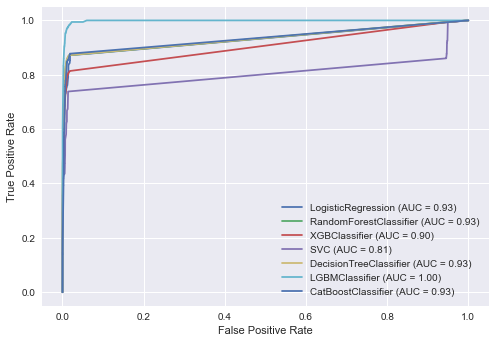

In [43]:
# Plot Receiver operating characteristic (ROC) curve.
classifiers = [classifier_log, classifier_forest, classifier_xgb, classifier_svm, classifier_tree]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_train, y_train, ax=ax)
plot_roc_curve(classifier_lgbm, X_train_cat, y_train_cat, ax=ax)
plot_roc_curve(classifier_catb, X_train_cat, y_train_cat, ax=ax)

### Zadanie 9. Wszystkie oszacowane wcześniej modele proszę wykorzystać do wygenerowania prognoz na próbie testowej. Proszę porównać jakość prognoz pod względem wybranych charakterystyk (co najmniej accuracy, sensitivity, specificity, precision, AUCROC, F1) i krótko omówić wnioski płynące z tego porównania. Proszę zestawić na jednym wykresie krzywe ROC dla wszystkich modeli w próbie testowej i krótko go skomentować.

In [44]:
# Lista pred zawiera predykcje dla zbioru testowego. 
pred = [y_pred_log_test, y_pred_forest_test, y_pred_xgb_test, y_pred_catb_test, y_pred_light_test, y_pred_tree_test, y_pred_kernel_svm_test]
model = ["log", "forest", "xgb", "catb", "light", "tree", "kernel_svm"]
# Making the Confusion Matrix

### table with metrics
accuracy_list = []
roc_list = []
confusion_list = []
summary_list = []
log_loss_list = []
for y_pred in pred:
    log_loss = metrics.log_loss(y_test, y_pred)
    log_loss_list.append(round(log_loss, 6))
    cm = confusion_matrix(y_test, y_pred)
    confusion = [cm[0][0], cm[0][1], cm[1][0], cm[1][1]]
    confusion_list.append(confusion)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    summary = pd.DataFrame(metrics.precision_recall_fscore_support(y_test, y_pred), index=["precision", "recall", "fscore","support"]).transpose()
    summary_list.append(summary)
    # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    auc = metrics.roc_auc_score(y_test, y_pred)
    roc_list.append(auc)
  

accuracy_comparison = pd.DataFrame(accuracy_list, columns = ["accuracy score"], index = model)
roc_auc_score = pd.DataFrame(roc_list, columns = ["roc_auc_score"], index = model)
confusion  = pd.DataFrame(confusion_list, columns = ["True Positive", "False Positive", "False Negative", "True Negative"], index = model)
log_loss =  pd.DataFrame(log_loss_list, columns = ["log_loss"], index = model)
sum_0 = pd.DataFrame([summary_list[i].iloc[0,] for i in range(7)], index = model)
sum_0.columns = ["precision_0", "recall_0", "fscore_0","support_0"]
#columns= ["precision_0","recall_0", "fscore_0","support_0"] )
sum_1 = pd.DataFrame([summary_list[i].iloc[1,] for i in range(7)], index = model )
sum_1.columns = ["precision_1", "recall_1", "fscore_1","support_1"]

final_metrics = pd.concat([accuracy_comparison, roc_auc_score, confusion, sum_0, sum_1, log_loss], axis = 1)

print(final_metrics)


            accuracy score  roc_auc_score  True Positive  False Positive  \
log               0.998200       0.518165          29944               1   
forest            0.998100       0.608857          29931              14   
xgb               0.998233       0.554479          29941               4   
catb              0.998233       0.554479          29941               4   
light             0.998167       0.608891          29933              12   
tree              0.998133       0.554429          29938               7   
kernel_svm        0.998167       0.554445          29939               6   

            False Negative  True Negative  precision_0  recall_0  fscore_0  \
log                     53              2     0.998233  0.999967  0.999099   
forest                  43             12     0.998565  0.999532  0.999049   
xgb                     49              6     0.998366  0.999866  0.999116   
catb                    49              6     0.998366  0.999866  0.999116   
l

#### Analiza wyników 
- Accuracy score dla wszystkich modeli ma podobne wartosci.

- Roc auc score -  Area Under the Receiver Operating Characteristic Curve (ROC AUC) - najlepsze wyniki w przypadku dwoch modeli LGBM( 0.608891) oraz Random Forest (0.608857).

Analiza confiusion matrix:  
- Dla wszystkich modeli True Positive maja podobne wyniki. 
- True negative najwyzsze dla modelu LGBM oraz False Negative najnizsze dla modelu LGBM jednkaże wynik False Positive dla tego modelu jest wysoki.
  
-  Miary Recall oraz F1 score maja najwyzsze wyniki dla modelu LGBM. Najwyzszy wynik metryki Precision dla modelu catboost 0.750000, jednakże dla modelu LGBM daje sredni wynik 0.500000. 

Na podstawie zaobserwowanych wynikow można stwierdzic ze model LGBM ma najlepsze dopasowanie na zbiorze testowym.

C:\Users\ANIA\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


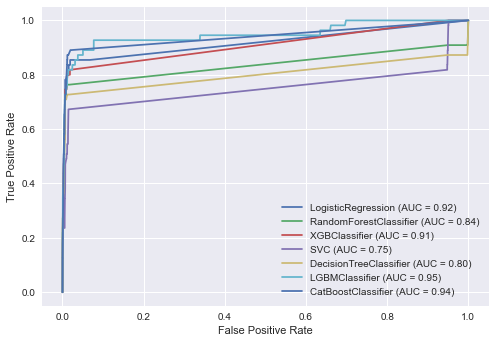

In [48]:
# Plot Receiver operating characteristic (ROC) curve.
classifiers = [classifier_log, classifier_forest, classifier_xgb, classifier_svm, classifier_tree]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)
plot_roc_curve(classifier_lgbm, X_test_cat, y_test_cat, ax=ax)
plot_roc_curve(classifier_catb, X_test_cat, y_test_cat, ax=ax)

#### Analiza wykresu
Metryka ROC Curve przyjmuje najwyższe wartosci, co potwierdza najlepsze dopasowanie tego modelu do danych.

### Zadanie 10. Proszę zaproponować (i ewentualnie zastosować) inne elementy analizy (ale nie nowe modele), które mogłyby potencjalnie poprawić jakość szacowanych modeli. W przypadku zastosowania, prośba o krótki komentarz do wyników.

Jakość modeli można poprawic stosując metode grid search. Polegałoby to na przeliczeniu wcześniej analizowanych modeli, dla róznych prarametrów modelu a następnie wybranie parametrów dla których model ma najwiekszą siłe predykcyjną.